# Maryland voter registration analysis

By [Christine Zhang](mailto:czhang@baltsun.com)

The Baltimore Sun conducted an analysis of Maryland voter registration statistics from the state's Board of Elections.

The analysis provided information for the October 15, 2018 Baltimore Sun story titled ["Maryland nears record high voter registration — and independents make up the fastest-growing group"](http://www.baltimoresun.com/news/maryland/politics/bs-md-2018-voter-registration-20181011-story.html).

Here are the key findings of the data analysis, which is documented below and based on data from the Maryland State Board of Elections [Monthly Voter Registration Activity Reports](https://elections.maryland.gov/voter_registration/stats.html):

- As September 30, 2018, 18 percent of voters were registered as "unaffiliated."
- The number of unaffiliated voters increased by 8 percent between September 2014 and September 2018.
- Democrats and Republicans each saw 6 percent increases over the four-year period between September 2014 and September 2018.
- Unaffiliated voters make up more than 20 percent of active, registered voters in eight Maryland counties.
- There have been more recent increases in unaffiliated voters since 2016.
- As September 30, 2018, the number of active, registered voters was 3,975,309 — just a couple thousand short of the state record of 3,977,637, set in January 2017.
- Democrats continue to hold a 2-to-1 registration advantage over Republicans, making up slightly more than half of active, registered voters.
- Like Republicans, Democrats saw a rise in registrations right before the 2016 presidential election.

## How we did it

### Run `01_processing.ipynb`

The Maryland State Board of Elections provides the Monthly Voter Registration Activity Reports as PDFs. 

Data was extracted from the January through September 2018 reports (September 2018 was the most recent data available at the time of publication), and from the September 2014 and September 2016 reports (for a point-in-time comparison of 2018 with the most recent election years), using [Tabula](https://tabula.technology/), an open-source tool "for liberating data tables trapped inside PDF files."

The `01_processing.ipynb` notebook contains code that was used to process and combine the files for each month and year into cleaned data files for analysis.

The cleaned CSV files are in the `output/` folder:
- `totals.csv`: total active registration, by county and party
- `changes.csv`: voter registration changes, by county and change type (address or name, or changes from* a particular party)
- `new.csv`: new registrations, by party and method of registration
- `removals.csv`: removals from the registered voter list, by party and reason for removal

Our story only uses the `totals.csv` file, but we have included the other files for completeness, so that others may conduct their own analyses.

The files in the `input/` folder correspond exactly to the columns in the PDF reports. The PDFs for each month and year are in the `pdf/` folder, for reference.

\*The state does not track which party voters switched to.

### Import R data analysis libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('lubridate'))
suppressMessages(library('reshape2'))

Read in the `totals.csv` data for analysis.

In [2]:
totals <- suppressMessages(read_csv('output/totals.csv'))

Here are the first six rows:

In [3]:
head(totals)

county,dem,rep,grn,lib,unaf,oth,total,date,conf.mailing,inactive,dem_perc,rep_perc,grn_perc,lib_perc,unaf_perc,oth_perc
ALLEGANY,13864,21284,135,284,7117,302,42986,2018-01-31,234,2981,32.25236,49.513795,0.3140557,0.6606802,16.55655,0.7025543
ANNE ARUNDEL,159780,134468,832,2708,82760,1223,381771,2018-01-31,4660,21399,41.85231,35.222162,0.2179317,0.7093257,21.67792,0.3203491
BALTIMORE CITY,301200,31039,1264,1416,45782,1658,382359,2018-01-31,5347,27109,78.77414,8.117764,0.3305794,0.3703326,11.97356,0.4336239
BALTIMORE CO.,305849,142241,1449,3096,90743,4448,547826,2018-01-31,6215,28367,55.82959,25.964631,0.2645000,0.5651429,16.56420,0.8119366
CALVERT,23607,26554,136,489,13265,393,64444,2018-01-31,2012,4291,36.63180,41.204767,0.2110359,0.7587983,20.58376,0.6098318
CAROLINE,6853,9156,29,107,3821,117,20083,2018-01-31,98,1039,34.12339,45.590798,0.1444007,0.5327889,19.02604,0.5825823


### Finding: As September 30, 2018, 18 percent of voters were registered as "unaffiliated."

Filter the `totals` dataframe to include county totals for September 30, 2018. The `unaf_perc` column provides the percent of active, registered voters who were "unaffiliated."

In [4]:
totals %>% filter(county == 'Total' & date == '2018-09-30') %>% select(unaf_perc)

unaf_perc
18.04056


In [5]:
print(paste("As September 30, 2018,", 
            trunc(totals %>% filter(county == 'Total' & date == '2018-09-30') %>% select(unaf_perc)),
            "percent of voters were registered as unaffiliated."))

[1] "As September 30, 2018, 18 percent of voters were registered as unaffiliated."


### Finding: The number of unaffiliated voters increased by 8 percent between September 2014 and September 2018.

Create a dataframe, `totals.pch`, which consists of the percent change between 2014 and 2018 (`pch_14_*`) as well as the percent change between 2016 and 2018 for each party (`pch_16_*`). Other parties (not Democrat or Republican) are combined into `other`.

In [6]:
totals.pch <- totals %>% mutate(other_perc = grn_perc + lib_perc + oth_perc, 
                                other = grn + lib + oth) %>% 
                         select(-grn_perc, -lib_perc, -oth_perc) %>%
                         group_by(county) %>% 
                         filter(date == '2014-09-30' | 
                                date == '2016-09-30' | 
                                date == '2018-09-30') %>% 
                         arrange(county, date) %>% 
                         mutate(pch_16_dem = (dem/lag(dem) - 1) * 100, 
                                pch_16_rep = (rep/lag(rep) - 1) * 100, 
                                pch_16_unaf = (unaf/lag(unaf) - 1) * 100,
                                pch_16_other = (other/lag(other) - 1) * 100,
                                pch_14_dem = (dem/lag(dem, 2) - 1) * 100, 
                                pch_14_rep = (rep/lag(rep, 2) - 1) * 100, 
                                pch_14_unaf = (unaf/lag(unaf, 2) - 1) * 100,
                                pch_14_other = (other/lag(other, 2) - 1) * 100) %>% 
  filter(date == '2018-09-30') %>%
  ungroup() %>%
  select(-conf.mailing, -inactive)

The `pch_14_unaf` column provides the percent chnage in active, registered unaffiliated voters between 2014 and 2018. For the story, we chose to compare 2018 to 2014, since that was the year of the last midterm elections.

In [7]:
totals.pch %>% filter(county == 'Total') %>% select(pch_14_unaf)

pch_14_unaf
8.17601


In [8]:
print(paste("The number of unaffiliated voters increased by", 
            trunc(totals.pch %>% filter(county == 'Total') %>% select(pch_14_unaf)),
            "percent between September 2014 and September 2018."))

[1] "The number of unaffiliated voters increased by 8 percent between September 2014 and September 2018."


### Finding: Democrats and Republicans each saw 6 percent increases over the four-year period between September 2014 and September 2018.

The `pch_14_dem` and `pch_14_rep` columns provide the percent chnage in active, registered Democratic and Republican voters between 2014 and 2018. For the story, we chose to compare 2018 to 2014, since that was the year of the last midterm elections.

In [9]:
totals.pch %>% filter(county == 'Total') %>% select(pch_14_dem, pch_14_rep)

pch_14_dem,pch_14_rep
6.646361,6.358201


In [10]:
print(paste("The number of Democratic voters increased by", 
            trunc(totals.pch %>% filter(county == 'Total') %>% select(pch_14_dem)),
            "percent between September 2014 and September 2018."))

print(paste("The number of Republican voters increased by", 
            trunc(totals.pch %>% filter(county == 'Total') %>% select(pch_14_rep)),
            "percent between September 2014 and September 2018."))

[1] "The number of Democratic voters increased by 6 percent between September 2014 and September 2018."
[1] "The number of Republican voters increased by 6 percent between September 2014 and September 2018."


### Finding: Unaffiliated voters make up more than 20 percent of active, registered voters in eight Maryland counties.

Filter the `totals` dataframe to include counties with more than 20 percent of registered unaffiliateds as of September 30, 2018. These are the eight counties:

In [11]:
totals %>% filter(date == '2018-09-30' & unaf_perc > 20) %>% 
           arrange(desc(unaf_perc)) %>% mutate(row_number = row_number()) %>% select(row_number, county, unaf_perc)

row_number,county,unaf_perc
1,FREDERICK,22.85382
2,HOWARD,22.51406
3,CECIL,22.01056
4,MONTGOMERY,21.93508
5,ANNE ARUNDEL,21.77415
6,ST. MARY'S,20.58683
7,CALVERT,20.49780
8,WASHINGTON,20.32497


### Finding: There have been more recent increases in unaffiliated voters since 2016.

For the story, we chose to compare 2018 to 2014, since that was the year of the last midterm elections. However, we can also compare 2018 with the most recent presidential election year, 2016. The `pch_16_unaf`, `pch_16_dem` and `pch_16_rep` columns in the `totals.pch` dataframe provide the percent chnage in active, registered unaffiliated, Democratic and Republican voters between 2014 and 2018. 

In [12]:
totals.pch %>% filter(county == 'Total') %>% select(pch_16_unaf, pch_16_dem, pch_16_rep)

pch_16_unaf,pch_16_dem,pch_16_rep
5.635676,1.824224,0.06177157


Increases in unaffiliated registered voters have outpaced that of Democrats and Republicans since 2016.

### As September 30, 2018, the number of active, registered voters was 3,975,309 — just a couple thousand short of the state record of 3,977,637, set in January 2017.

Filter the data to include the total number of active, registered voters as of September 30, 2018.

In [13]:
totals %>% filter(county == 'Total' & date == '2018-09-30') %>% select(total)

total
3975309


The record high number of 3,977,637 for January 31, 2017 was obtained by reviewing the State Board of Election Monthly Voter Registration Activity Reports: https://elections.maryland.gov/voter_registration/stats.html.

### Finding: Democrats continue to hold a 2-to-1 registration advantage over Republicans, making up slightly more than half of active, registered voters.

Create a column, `dem_rep_ratio`, that represents the ratio of Democrats to Republicans in terms of active, registered voters.

In [14]:
totals <- totals %>% mutate(dem_rep_ratio = dem/rep)

Filter to the total for all counties:

In [15]:
totals %>% filter(county == 'Total') %>% select(date, dem_rep_ratio, dem, rep) %>% 
           arrange(date)

date,dem_rep_ratio,dem,rep
2014-09-30,2.139903,2043479,954940
2016-09-30,2.108561,2140253,1015030
2018-01-31,2.120768,2133813,1006151
2018-02-28,2.121533,2134776,1006242
2018-03-31,2.124091,2136893,1006027
2018-04-30,2.126237,2141975,1007402
2018-05-30,2.129083,2149873,1009765
2018-06-30,2.133123,2155862,1010660
2018-07-31,2.137281,2160753,1010982
2018-08-30,2.142831,2169094,1012256


The ratio of active, registered Democrats to active, registered Republicans as of September 30, 2018 is around 2:1. This has been the case since at least September 2014.

### Finding: Like Republicans, Democrats saw a rise in registrations right before the 2016 presidential election.

The `historical_registration.csv` file in the `output` folder contains voter registration totals for the months of January and September between 2000 and 2018. These were obtained from the State Board of Election Monthly Voter Registration Activity Reports for those months and years: https://elections.maryland.gov/voter_registration/stats.html, and the `source` column in the CSV provides links to the individual PDF reports.

In [16]:
historical <- suppressMessages(read_csv("output/historical_registration.csv"))

Create a column, `party2`, which combines party categories other than Democrat, Republican and unaffiliated into a single category called "other." Note that the third parties recognized by the state have changed over the years. Also note that in 2000 and January 2001, unaffiliated voters were not placed into their own category (`dec/oth` refers to voters who declined to register with a party as well as voters who specfied other parties).

In [17]:
historical <- historical %>% mutate(date = mdy(date), 
                                    party2 = case_when(party == 'dem' ~ 'dem',
                                                       party == 'rep' ~ 'rep',
                                                       party == 'unaf' ~ 'unaf',
                                                       party == 'total' ~ 'total',
                                                       TRUE ~ 'other'))

Calculate the percent change between the Septembers of each year.

In [18]:
historical.pch <- historical %>% filter(month == 'September') %>% group_by(date, party2) %>%
               summarise(n = sum(number)) %>% ungroup() %>% 
               arrange(party2, date) %>% group_by(party2) %>%
               mutate(pch = (n/lag(n) - 1) * 100)

The `pch` column for `date == 2016-09-30` represents the percent change in active, registered voters by party between September 30, 2015 and September 30, 2016.

In [19]:
historical.pch %>% filter(date == '2016-09-30')

date,party2,n,pch
2016-09-30,dem,2140253,5.9426294
2016-09-30,other,58136,2.3683330
2016-09-30,rep,1015030,5.7729481
2016-09-30,total,3892326,4.6459502
2016-09-30,unaf,678907,-0.5842755


Democrats and Republicans both saw rises in registrations during this period.

## Plots included in the story

Versions of the following plots were included in the story:

### Active, registered voters by party as of January 31 of each year from 2002-2018 (plus Sept. 30, 2018)

Here is a plot of active, registered voters by party as of January 31 of each year from 2002 (the first year for which unaffiliated voters were broken out separately) through 2018. Note that registration as of September 30, 2018 is also plotted as the rightmost bar.

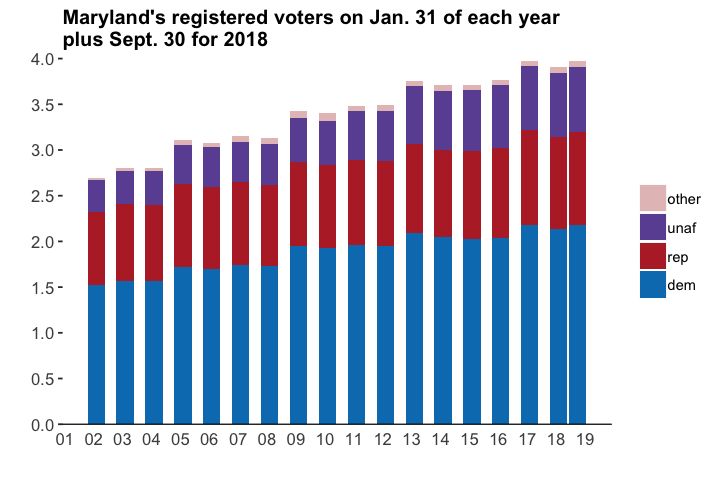

In [21]:
options(repr.plot.width = 6, repr.plot.height = 4)

historical$party2.f <- factor(historical$party2, 
                           levels = c('other',  
                                      'unaf', 'rep','dem'))

print(ggplot(historical %>% filter(year > 2001 & (month == 'January' | year == 2018) & 
                        party2.f != 'total'), aes(x = date, y = number/1000000, 
                                                             group = party2.f, fill = party2.f)) +
  geom_bar(stat='identity') + labs(x = '', y = '', 
                                   title = "Maryland's registered voters on Jan. 31 of each year\nplus Sept. 30 for 2018") +
  scale_x_date(date_breaks = "year", date_minor_breaks = "1 week", 
               date_labels = "%y") +
  scale_y_continuous(breaks = seq(0, 4,.5), limits = c(0,4), expand = c(0,0)) +
  scale_fill_manual(values = c('#E5C1C1', '#6B52A2', '#B82B30','#007DBE' )) +
  theme(panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text = element_text(size = 10), 
        plot.title = element_text(size = 12, face = "bold"),
        axis.ticks.x = element_blank(),
        axis.line.x = element_line(),
        legend.title = element_blank()))

### Active, registered voters by party for each county as of September 30, 2018

Here is a plot of active, registered voters by party for each county as of September 30, 2018.

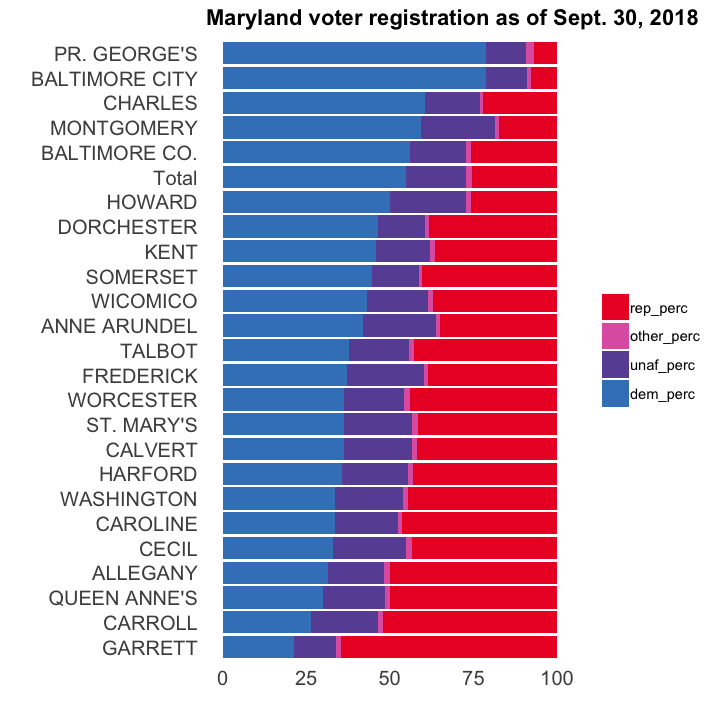

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)

totals.m <- melt(totals %>% mutate(other_perc = grn_perc + lib_perc + oth_perc, 
                                other = grn + lib + oth) %>% 
                         select(-grn_perc, -lib_perc, -oth_perc), id.vars = c('county', 'date'))
totals.m$party.f <- factor(totals.m$variable, 
                                levels = c('rep_perc', 'other_perc', 'unaf_perc',  
                                           'dem_perc'))

sep.totals <- totals.m %>% filter(date == '2018-09-30')
sep.dem <- sep.totals %>% filter(variable == 'dem_perc')

sep.totals$county.f <- factor(sep.totals$county, 
                              levels = sep.dem$county[order(sep.dem$value)])

print(ggplot(sep.totals %>% filter(grepl('perc', variable))) + 
  geom_bar(aes(x = county.f, y = value, fill = party.f), stat="identity") +
  coord_flip() + scale_fill_manual(values = c('#eb212e', '#df65b0', '#6a51a3', '#3e83c2')) + 
  theme(panel.grid.minor.x = element_blank(), plot.title = element_text(face = "bold"),
                                          axis.ticks = element_blank(),
                                          axis.text = element_text(size = 12),
                                          panel.background = element_blank(),
                                          legend.title = element_blank()) + labs(x = '', 
                                                                                 y= '', title = 'Maryland voter registration as of Sept. 30, 2018'))



Note: the story also includes some historical information on voter reigstration in Maryland prior to the year 2000 (the earliest year for which the State Board of Elections produces monthly reports). For example, the following passage:
>"In 1978, the Maryland electorate was 70 percent Democratic, 23 percent Republican and 7 percent independent. Most of the shift appears to have been among Democrats, as Republican registration has remained in a narrow band between 23 percent and 27 percent since at least 1962."

This information was provided by political scientist Todd Eberly, citing a book by former Maryland Secretary of State and executive in residence at the University of Baltimore’s School of Public and International Affairs [John T. Willis](http://www.ubalt.edu/cpa/faculty/alphabetical-directory/john-t-willis.cfm), "Presidential Elections in Maryland."